In [1]:
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils

# for the IDE:
import numpy_ as np
import spatial, model, inputs

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 10,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 10,
    'sequence_count': 10,
    'ISI': 500*ms,
}

In [4]:
A, B = 0, 2

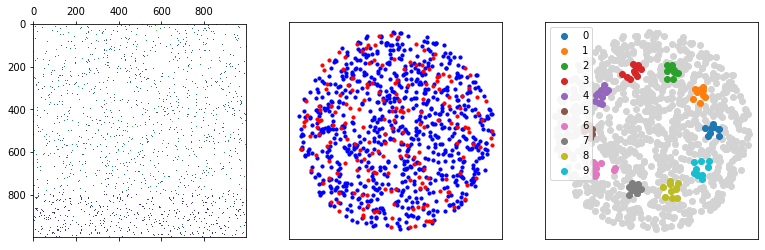

In [5]:
# X, Y, W, D = spatial.create_weights(params, rng)
f = np.load('overlap.npz')
X, Y, W, D = f['X']*meter, f['Y']*meter, f['W'], f['D']
Xstim, Ystim = spatial.create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = spatial.get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SpikeMon_{k}'].t/second, net[f'SpikeMon_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SpikeMon_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

In [7]:
def get_episode_spikes(Net, params, episode=0, sorted=True):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t > t0) & (t < t0 + episode_duration)
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    return I, T

In [8]:
def get_neuron_spike_counts(N, pulsed_i, sequence, target_item):
    numspikes = np.zeros(N, dtype=int)
    for pulse_idx, pulse_item in enumerate(sequence):
        if pulse_item == target_item:
            np.add.at(numspikes, pulsed_i[pulse_idx], 1)
    return numspikes

In [9]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [10]:
def get_pulse_spike_counts(Net, params):
    I, T = get_episode_spikes(Net, params)
    return get_pulse_spike_counts_TMP(T, params['ISI'])

In [11]:
def populate_spike_results(Net, params, results):
    results['nspikes'] = get_pulse_spike_counts(Net, params)
    results['spike_i'], results['spike_t'] = get_episode_spikes(Net, params)
    results['pulsed_i'], results['pulsed_t'] = zip(*list(iterspikes(
        results['spike_i'], results['spike_t'],
        params['sequence_length']*params['sequence_count'], params['ISI'])))
    results['pulsed_nspikes'] = np.zeros((len(results['pulsed_i']), params['N']), int)
    for j, i in enumerate(results['pulsed_i']):
        np.add.at(results['pulsed_nspikes'][j], i, 1)

In [12]:
device.reinit()
device.activate()

probe = {**params, 'sequence_length': params['sequence_length']-1, 'sequence_count': 1}
Net = model.create_network(X, Y, Xstim, Ystim, W, D, probe, reset_dt=probe['settling_period'] + probe['ISI']*probe['sequence_length'])
T = 0*second
for i in range(probe['N_stimuli']):
    T = inputs.set_input_sequence(Net, [i]*probe['sequence_length'], probe, offset=T)
Net.run(T)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


Exc 288.88636364 mHz
Inh 0.34627273 Hz


<AxesSubplot:xlabel='seconds'>

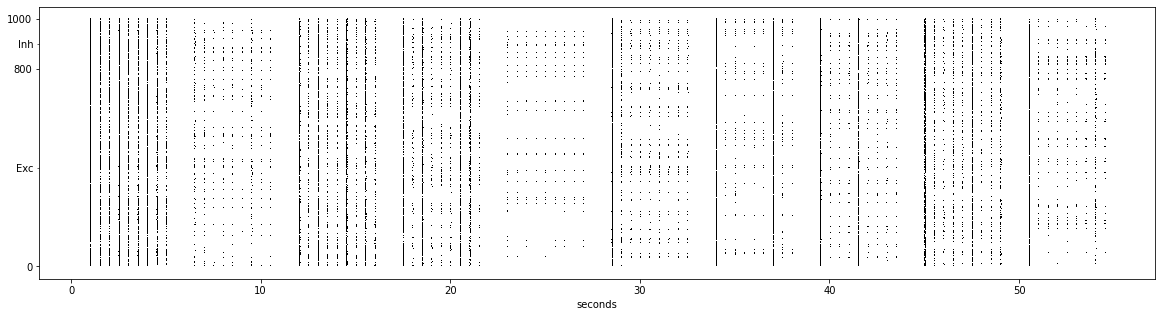

In [13]:
raster(Net)

In [14]:
spike_i, spike_t = [0]*probe['N_stimuli'], [0]*probe['N_stimuli']
for i in range(probe['N_stimuli']):
    spike_i[i], spike_t[i] = get_episode_spikes(Net, probe, i)

spike_n = np.zeros((probe['N_stimuli'], probe['N']), dtype=int)
for i in range(probe['N_stimuli']):
    np.add.at(spike_n[i], spike_i[i], 1)
spike_n.sum(axis=1)

array([3613,  592, 2610, 1971,  313, 1349, 1581, 1474, 1862, 1155])

In [15]:
Cx = np.arange(probe['N_stimuli'])
Cx[A] = Cx[B] = -1
Cx = Cx[Cx>=0]

In [16]:
classified_neurons = {}
for a in [True, False]:
    for b in [True, False]:
        for cx in [True, False]:
            value = np.flatnonzero(
                ((spike_n[A]>0) == a)
                & ((spike_n[B]>0) == b)
                & ((spike_n[Cx].sum(axis=0)>0) == cx)
            )
            key = ''.join([char for char, present in zip(['A','B','Cx'], [a,b,cx]) if present])
            classified_neurons[key] = value
print([(key, len(value)) for key, value in classified_neurons.items()])

[('ABCx', 657), ('AB', 19), ('ACx', 135), ('A', 14), ('BCx', 50), ('B', 10), ('Cx', 75), ('', 40)]


In [17]:
device.reinit()
device.activate()

probe = {**params, 'sequence_length': 50, 'sequence_count': 1}
Net = model.create_network(X, Y, Xstim, Ystim, W, D, probe, reset_dt=probe['settling_period'] + probe['ISI']*probe['sequence_length'])
T = 0*second
for i in range(probe['N_stimuli']):
    T = inputs.set_input_sequence(Net, [i]*probe['sequence_length'], probe, offset=T)
Net.run(T)

In [18]:
plt.figure(figsize=(8,4))
max_pulse = 0
for i in range(probe['N_stimuli']):
    spike_i, spike_t = get_episode_spikes(Net, probe, i)
    active_i = np.zeros(probe['N'], int)
    num_active = []
    for pulse_i, pulse_t in iterspikes(spike_i, spike_t, probe['sequence_length'], probe['ISI']):
        np.add.at(active_i, pulse_i, 1)
        num_active.append(np.sum(active_i>0))
    plt.plot(num_active)
    nzdiff = np.flatnonzero(np.diff(num_active) > 0)
    if nzdiff.size:
        max_pulse = max(max_pulse, nzdiff[-1]+1)
plt.ylabel('# unique neurons activated by stimulus')
plt.xlabel('Pulses')
plt.xlim(-1, max_pulse+1);

In [19]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params)
Astd = {}
Astd['Seq'], T = inputs.create_oddball(Net, params, A, B)
Net.run(T)
populate_spike_results(Net, params, Astd)

In [20]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params)
Bstd = {}
Bstd['Seq'], T = inputs.create_oddball(Net, params, B, A)
Net.run(T)
populate_spike_results(Net, params, Bstd)

In [21]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params)
MSC = {}
MSC['Seq'], T = inputs.create_MSC(Net, params, rng)
Net.run(T)
populate_spike_results(Net, params, MSC)

In [22]:
posthoc_class = {}
any_active = np.zeros((3, params['N']), bool)
for i, identity in enumerate(([A], [B], Cx)):
    # Mark neurons that are active in response to <identity> in any paradigm:
    for results in (Astd, Bstd, MSC):
        any_active[i] |= np.any(results['pulsed_nspikes'][np.isin(results['Seq'], identity)], axis=0)
for a in [True, False]:
    for b in [True, False]:
        for cx in [True, False]:
            target = np.asarray([a, b, cx])
            value = np.all(any_active == target[:, None], axis=0)
            key = ''.join([char for char, present in zip(['A','B','Cx'], [a,b,cx]) if present])
            posthoc_class[key] = np.flatnonzero(value)
print('a priori', [(key, len(value)) for key, value in classified_neurons.items()])
print('post hoc', [(key, len(value)) for key, value in posthoc_class.items()])

a priori [('ABCx', 657), ('AB', 19), ('ACx', 135), ('A', 14), ('BCx', 50), ('B', 10), ('Cx', 75), ('', 40)]
post hoc [('ABCx', 804), ('AB', 35), ('ACx', 70), ('A', 21), ('BCx', 25), ('B', 8), ('Cx', 20), ('', 17)]


In [23]:
# For each neuron, find the spike count in Astd, Adev, Amsc; Bstd, Bdev, Bmsc
# Plot these profiles, grouped by classification.

In [24]:
def get_stimulus_results(Std, Msc, Dev, target, params):
    npulses = np.array([np.sum(Std['Seq']==target), np.sum(Msc['Seq']==target), np.sum(Dev['Seq']==target)])
    spikes = np.zeros((3, params['N']))
    spikes[0] = get_neuron_spike_counts(params['N'], Std['pulsed_i'], Std['Seq'], target)
    spikes[1] = get_neuron_spike_counts(params['N'], Msc['pulsed_i'], Msc['Seq'], target)
    spikes[2] = get_neuron_spike_counts(params['N'], Dev['pulsed_i'], Dev['Seq'], target)
    spikes_per_target = spikes / npulses[:, None]
    return spikes, spikes_per_target, npulses

In [25]:
spikes_A, spikes_per_A, npulses_A = get_stimulus_results(Astd, MSC, Bstd, A, params)
spikes_B, spikes_per_B, npulses_B = get_stimulus_results(Bstd, MSC, Astd, B, params)

Text(0.5, 1.0, 'Response to A')

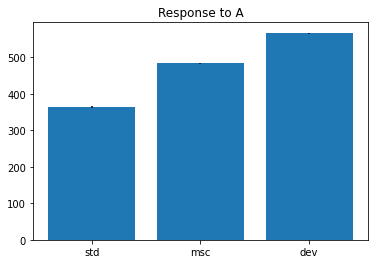

In [26]:
plt.bar(['std', 'msc', 'dev'], spikes_A.sum(axis=1)/npulses_A, yerr=spikes_A.std(axis=1)/np.sqrt(npulses_A))
plt.title('Response to A')

In [27]:
def plot_profiles_by_class(classes_to_use, classification, spikes_per):
    fig, axs = plt.subplots(3, 4, figsize=(16,8))
    for ax, key in zip(axs.T, classes_to_use):
        ax[0].set_title(key)
        ax[0].plot(spikes_per[:, classification[key]] / spikes_per[0, classification[key]])
        ax[0].set_xticks([0,1,2])
        ax[0].set_xticklabels(['std', 'msc', 'dev'])

        ax[1].plot(spikes_per[1:, classification[key]])
        ax[1].set_xticks([0,1])
        ax[1].set_xticklabels(['msc', 'dev'])

        ax[2].hist(spikes_per[2, classification[key]] - spikes_per[1, classification[key]])
        ax[2].set_xlabel('Dev - MSC')
        ax[2].axvline(0, c='r')

    axs[0,0].set_ylabel('Mean spikes per pulse\nrelative to standard response')
    axs[1,0].set_ylabel('Mean spikes per pulse')
    axs[2,0].set_ylabel('Number of neurons')

WARNING    /tmp/ipykernel_548742/3377686191.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(spikes_per[:, classification[key]] / spikes_per[0, classification[key]])
 [py.warnings]
WARNING    /tmp/ipykernel_548742/3377686191.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(spikes_per[:, classification[key]] / spikes_per[0, classification[key]])
 [py.warnings]


Text(0.5, 0.98, 'Post hoc classification')

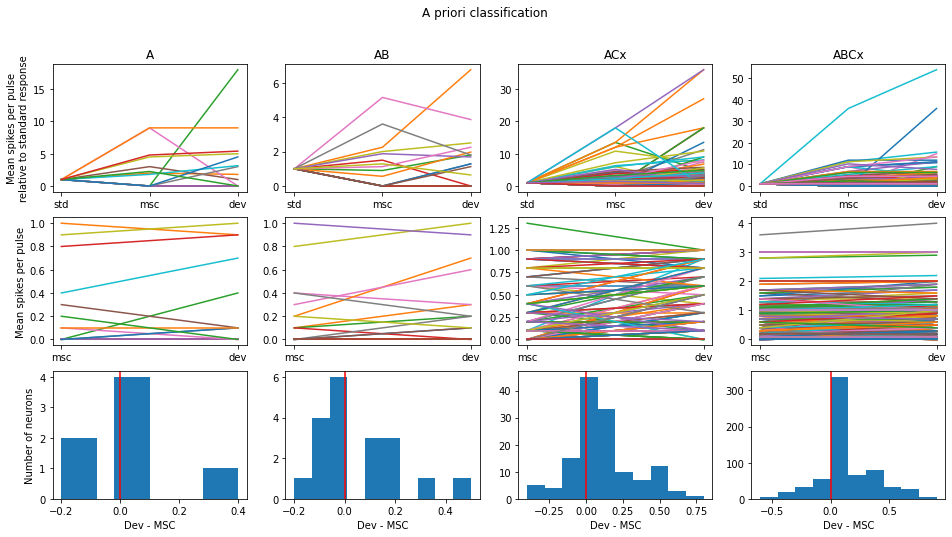

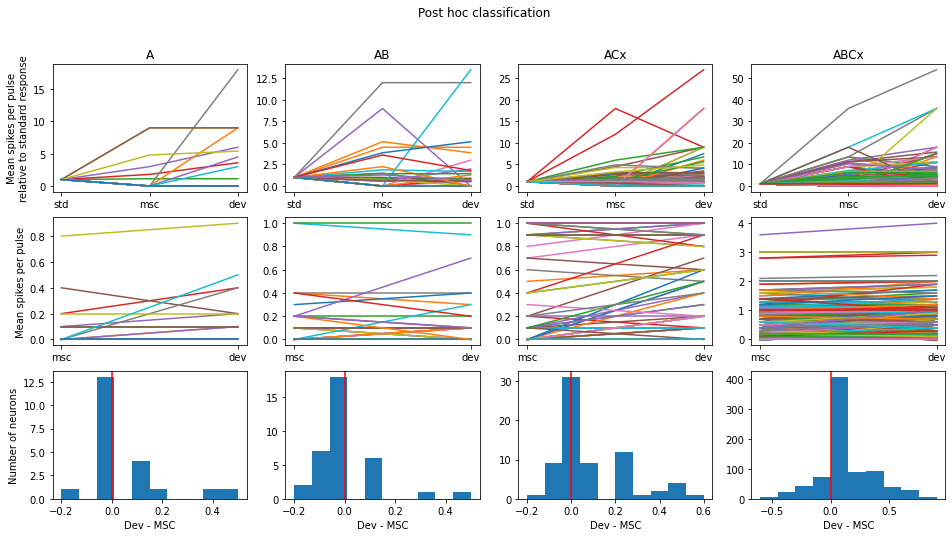

In [28]:
plot_profiles_by_class(['A', 'AB', 'ACx', 'ABCx'], classified_neurons, spikes_per_A)
plt.suptitle('A priori classification')

plot_profiles_by_class(['A', 'AB', 'ACx', 'ABCx'], posthoc_class, spikes_per_A)
plt.suptitle('Post hoc classification')

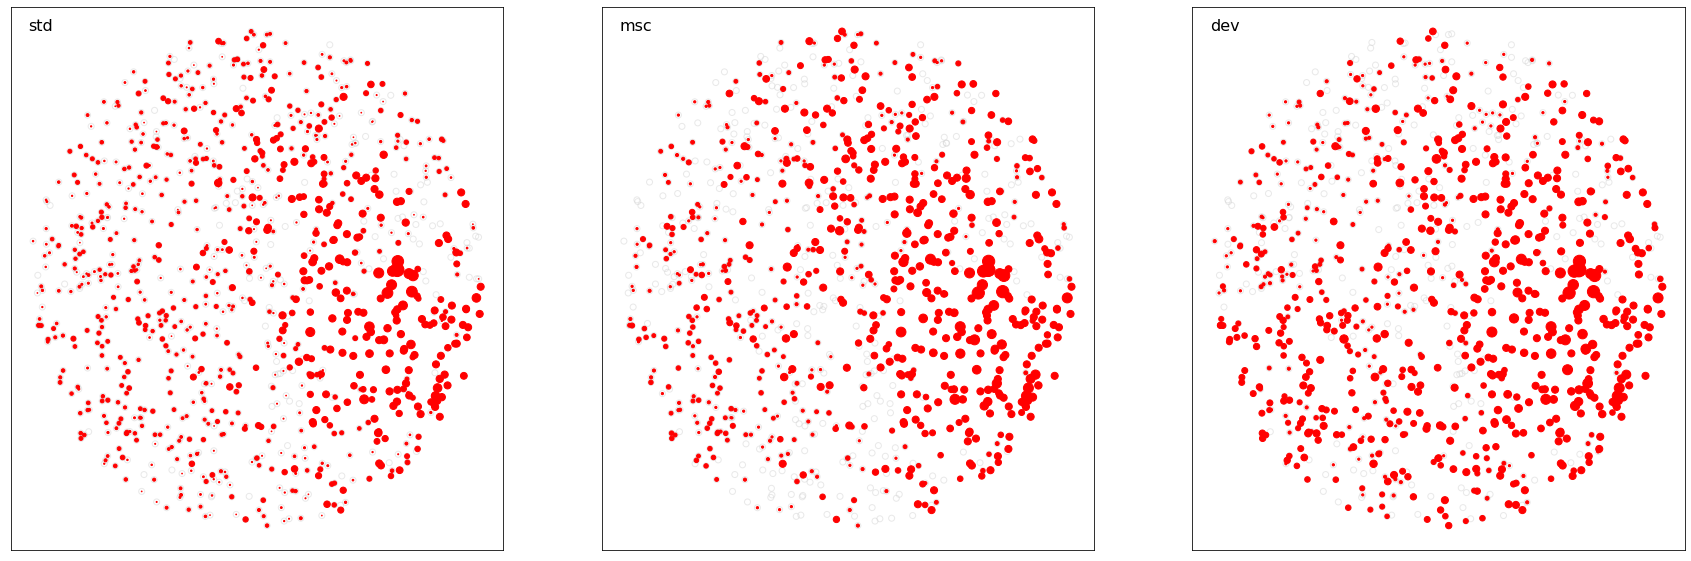

In [30]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
for i, (ax, label) in enumerate(zip(axs, ['std', 'msc', 'dev'])):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], params['r_dish'], label, fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    mask = spikes_A[i] > 0
    ax.scatter(X[mask], Y[mask], fc='r', s=50*spikes_per_A[i, mask])

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
labels = ['std', 'msc', 'dev']
for i, (ax, a, b) in enumerate(zip(axs, (2,1,2), (0,0,1))):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], 1.02*params['r_dish'], f'Green: responds to {labels[a]}, but not {labels[b]}', fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    mask = (spikes_A[a]>0) & (spikes_A[b]==0)
    ax.scatter(X[mask], Y[mask], color='green')
    mask = (spikes_A[a]==0) & (spikes_A[b] > 0)
    ax.scatter(X[mask], Y[mask], color='purple')

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
labels = ['std', 'msc', 'dev']
for i, (ax, a, b) in enumerate(zip(axs, (2,1,2), (0,0,1))):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], 1.02*params['r_dish'], f'{labels[a]}-{labels[b]}', fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    contrast = spikes_per_A[a] - spikes_per_A[b]
    vmax = np.max(np.abs(contrast))
    ax.scatter(X, Y, c=contrast>0, cmap='PiYG', s=50*np.abs(contrast))

In [46]:
def plot_class_locations(X, Y, params, classification):
    fig, axs = plt.subplots(2,3, figsize=(15,10))
    for ax, cat in zip(axs.flat, ['A', 'B', 'AB', 'ACx', 'BCx', 'ABCx']):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)
        ax.scatter(X[classification[cat]], Y[classification[cat]])
        ax.text(-params['r_dish'], params['r_dish'], cat)

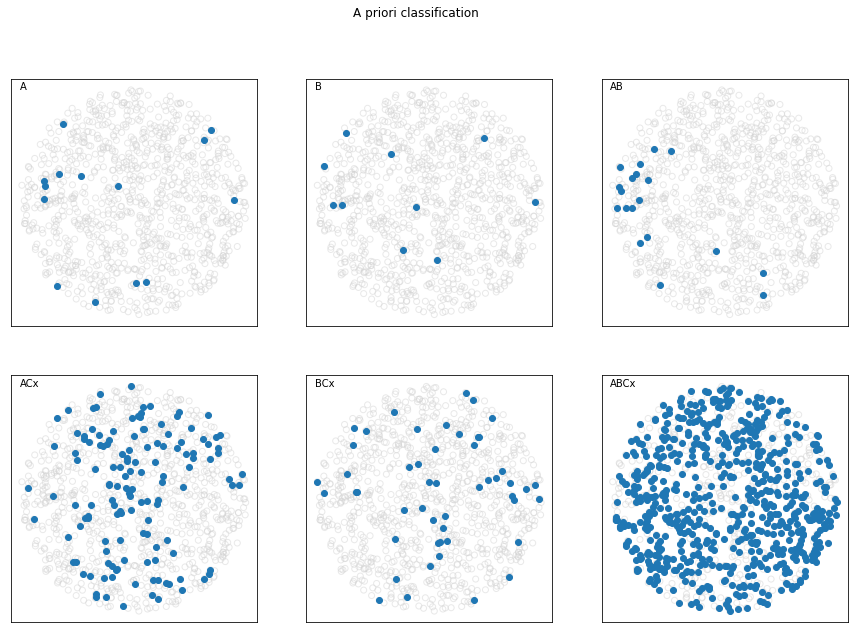

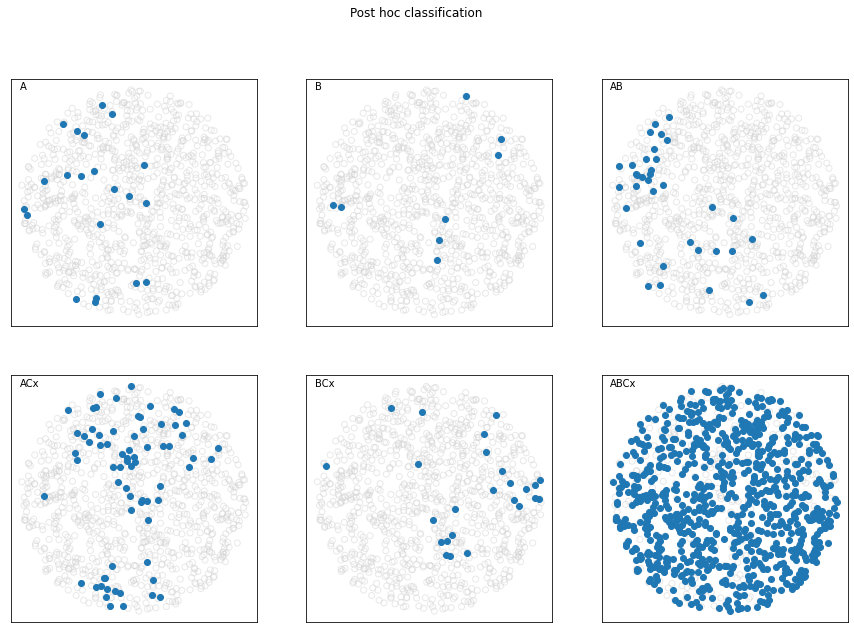

In [47]:
plot_class_locations(X, Y, params, classified_neurons)
plt.suptitle('A priori classification')

plot_class_locations(X, Y, params, posthoc_class)
plt.suptitle('Post hoc classification');

Text(0.5, 1.0, 'Response to B')

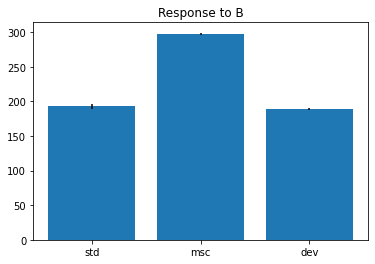

In [34]:
plt.bar(['std', 'msc', 'dev'], spikes_B.sum(axis=1)/npulses_B, yerr=spikes_B.std(axis=1)/np.sqrt(npulses_B))
plt.title('Response to B')

WARNING    /tmp/ipykernel_548742/3377686191.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(spikes_per[:, classification[key]] / spikes_per[0, classification[key]])
 [py.warnings]
WARNING    /tmp/ipykernel_548742/3377686191.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(spikes_per[:, classification[key]] / spikes_per[0, classification[key]])
 [py.warnings]


Text(0.5, 0.98, 'Post hoc classification')

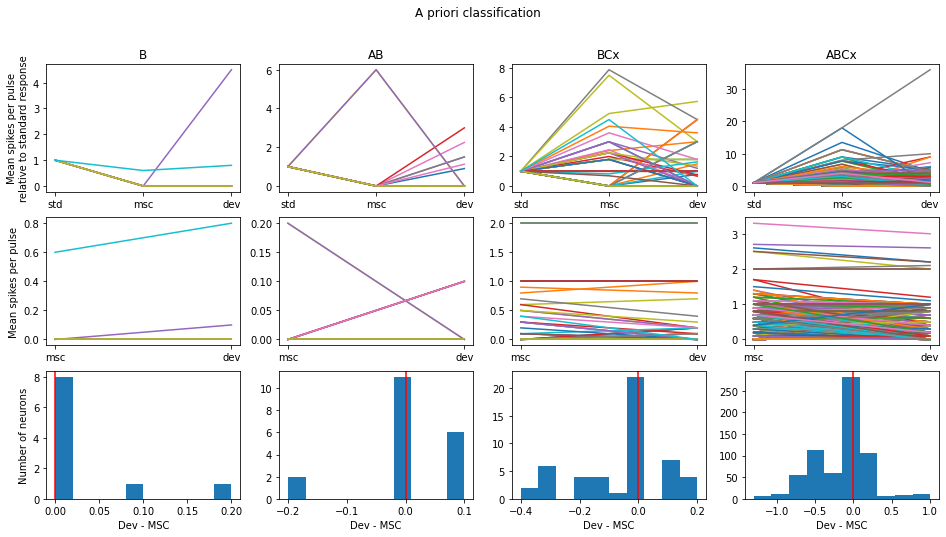

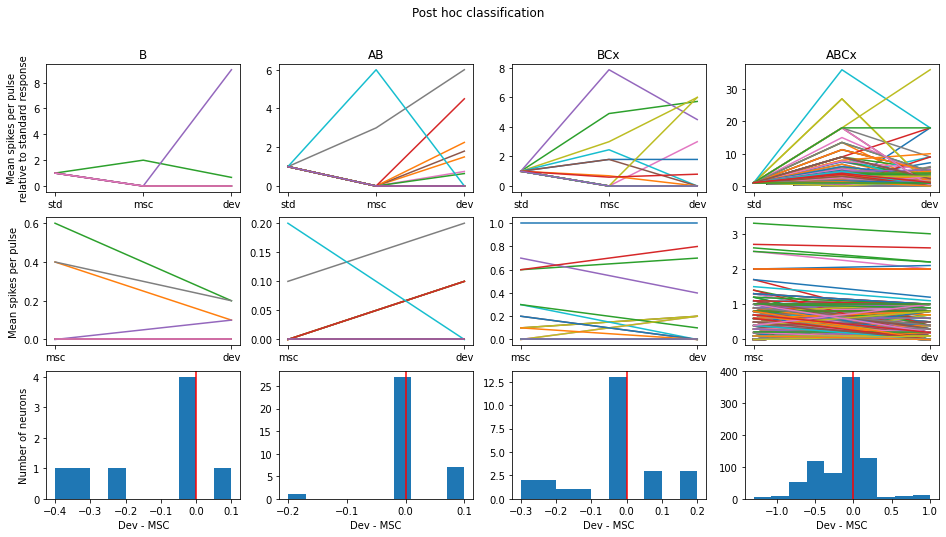

In [35]:
plot_profiles_by_class(['B', 'AB', 'BCx', 'ABCx'], classified_neurons, spikes_per_B)
plt.suptitle('A priori classification')

plot_profiles_by_class(['B', 'AB', 'BCx', 'ABCx'], posthoc_class, spikes_per_B)
plt.suptitle('Post hoc classification')

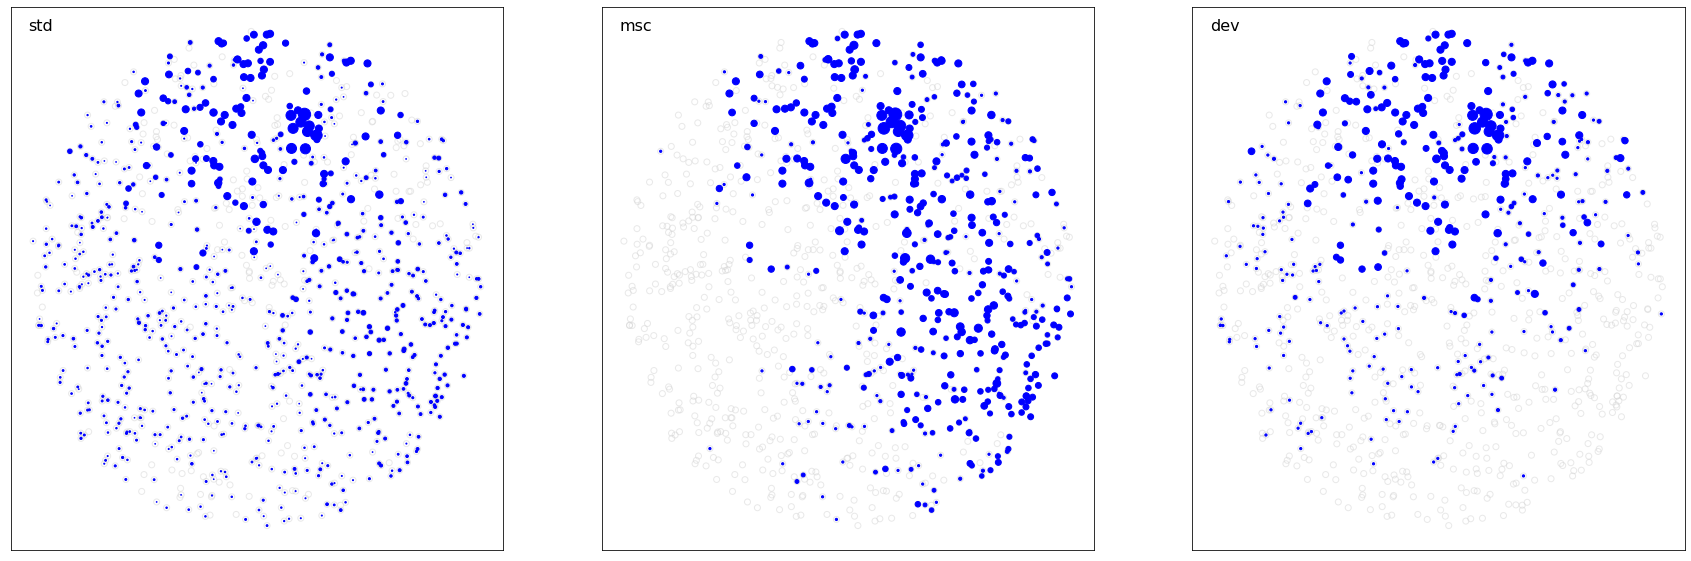

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
for i, (ax, label) in enumerate(zip(axs, ['std', 'msc', 'dev'])):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], params['r_dish'], label, fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    mask = spikes_B[i] > 0
    ax.scatter(X[mask], Y[mask], fc='b', s=50*spikes_per_B[i, mask])

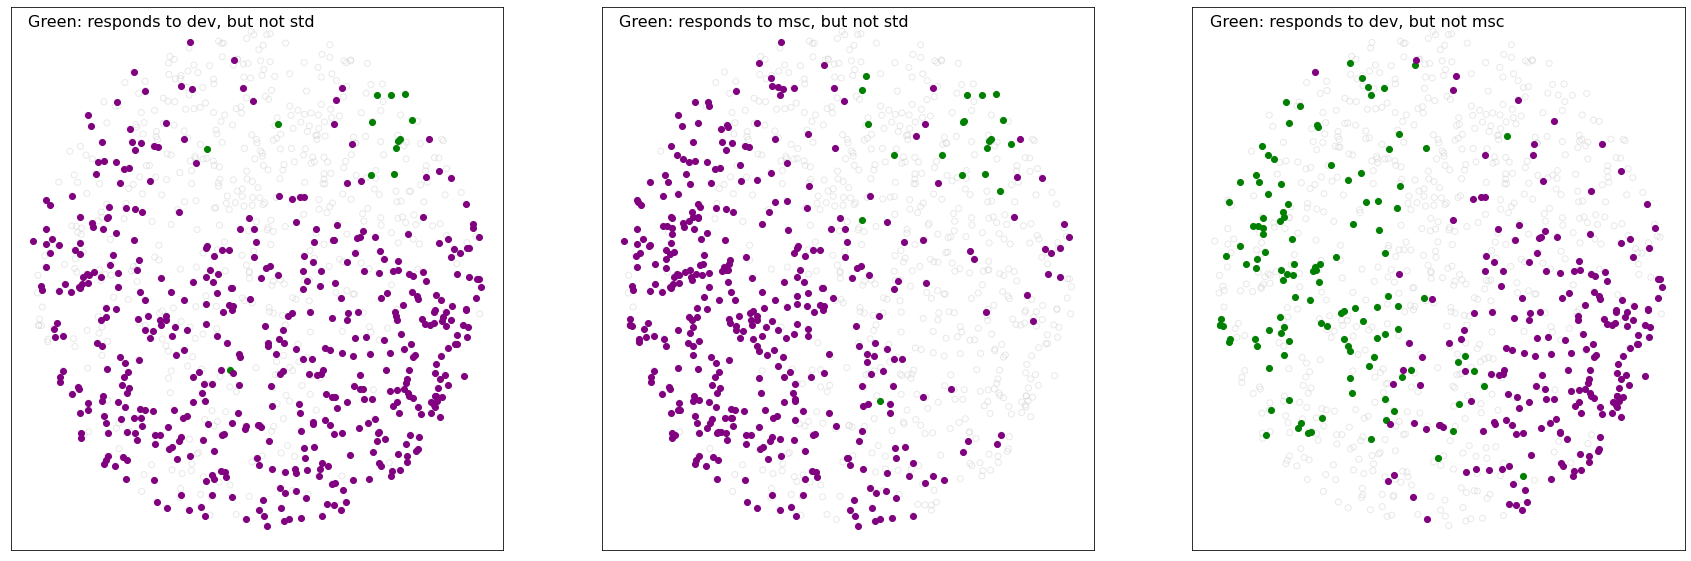

In [37]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
labels = ['std', 'msc', 'dev']
for i, (ax, a, b) in enumerate(zip(axs, (2,1,2), (0,0,1))):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], 1.02*params['r_dish'], f'Green: responds to {labels[a]}, but not {labels[b]}', fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    mask = (spikes_B[a]>0) & (spikes_B[b]==0)
    ax.scatter(X[mask], Y[mask], color='green')
    mask = (spikes_B[a]==0) & (spikes_B[b] > 0)
    ax.scatter(X[mask], Y[mask], color='purple')

In [38]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))
labels = ['std', 'msc', 'dev']
for i, (ax, a, b) in enumerate(zip(axs, (2,1,2), (0,0,1))):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-params['r_dish'], 1.02*params['r_dish'], f'{labels[a]}-{labels[b]}', fontsize=16)
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.5)

    contrast = spikes_per_B[a] - spikes_per_B[b]
    vmax = np.max(np.abs(contrast))
    ax.scatter(X, Y, c=contrast>0, cmap='PiYG', s=50*np.abs(contrast))